###This notebook shows the solution by team Polaris for the Challenge 3D Location Estimation Using RSSI of Wireless LAN, that ran from 2023-08-14 +03:00 to 2023-10-28 +03:00
###It was built on Google Colab on a normal CPU runtime, to reproduce the notebook, make sure you add the data path in the setup section and the data is renamed ***'train.csv', 'test.csv' and 'train_ap.xlsx'*** for conventional reasons.
###**Prepared by**: Ndabuye S. Gideon
###**Team**: Polaris
###BSc. in Software Engineering, University of Dodoma, Tanzania

# SetUp

In [168]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random
import numpy as np
import pickle

from sklearn.ensemble import HistGradientBoostingRegressor as HIST
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.multioutput import MultiOutputRegressor as MO
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE, max_error as ME, r2_score as r2s

from math import radians, cos, sin, asin, sqrt
from scipy.constants import speed_of_light as c

pd.set_option('display.max_columns', None)

warnings.filterwarnings("ignore")

In [169]:
# replace with the path of the directory
path = 'data/'

In [170]:
# seed everything for reproducibility
random_seed = 0
random.seed(random_seed)

In [171]:
# functions for generating new features
# Preprocessing functinos

def distance(lat1, lon1, lat2, lon2):
  lon1 = np.radians(lon1)
  lon2 = np.radians(lon2)
  lat1 = np.radians(lat1)
  lat2 = np.radians(lat2)

  # Haversine formula
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
  c = 2 * np.arcsin(np.sqrt(np.abs(a)))
  r = 6378137
  return (c * r)

def power_rssi(rssi, c):
  quo = (rssi - c) / (-1 * c)
  return quo ** np.e

def zton_rssi(rssi, c):
  quo = (rssi - c) / (-1 * c)
  return quo

def replace_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    column = column.apply(lambda x: upper_bound if x > upper_bound else x)
    column = column.apply(lambda x: lower_bound if x < lower_bound else x)
    return column

In [172]:
# define evaluation functions
def evaluate(y_test, predictions):
  mse = MSE(y_test, predictions)
  rmse = MSE(y_test, predictions, squared=False)
  mae = MAE(y_test, predictions)
  r2 = r2s(y_test, predictions)
  print('='*40)
  print(f'MSE:  {mse}')
  print(f'RMSE: {rmse}')
  print(f'MAE:  {mae}')
  print(f'R2:   {r2}')

def haversine_3d(lat1, lon1, height1, lat2, lon2, height2):
  # Radius of the Earth in meters
  R = 6378137

  # Convert latitude and longitude from degrees to radians
  lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

  # Haversine formula for latitude and longitude
  dlat = lat2 - lat1
  dlon = lon2 - lon1
  a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
  distance_2d = R * c

  # Calculate the 3D distance
  b = height2 - height1
  distance_3d = np.sqrt(distance_2d ** 2 + b ** 2)

  return distance_3d

def loc_eval(y_true, y_pred):
  if isinstance(y_true, pd.DataFrame):
    y_true = y_true.values.astype(np.float64)

  if isinstance(y_pred, pd.DataFrame):
    y_pred = y_pred.values.astype(np.float64)

  # Ensure that both input arrays have the same shape
  if y_true.shape != y_pred.shape:
      raise ValueError("Input arrays must have the same shape.")

  # Convert the data to float
  y_true = y_true.astype(float)
  y_pred = y_pred.astype(float)
  # Calculate the 3D Haversine distance for each data point
  distances = [haversine_3d(true_point[0], true_point[1], true_point[2], pred_point[0], pred_point[1], pred_point[2]) for true_point, pred_point in zip(y_true, y_pred)]
  # Calculate the average 3D localization error in meters
  avg_error = np.mean(distances)
  max_error = np.max(distances)
  print('='*40)
  print(f'Average Error (m): {avg_error}')
  print(f'Maximum Error (m): {max_error}')
  return avg_error, max_error, pd.Series(distances)

def match_precision(data):
  rounded_data = np.column_stack((np.round(data[:, 0], 8), np.round(data[:, 1], 8), np.round(data[:, 2], 1)))
  return rounded_data

# plotting outcomes of a predictino w.r.t the actual positions in 3D space
def plot_3d(y_test, predictions):
  actual_locations = np.array(y_test)
  predicted_locations = np.array(predictions)
  # Create a 3D scatter plot
  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(111, projection='3d')
  point_size = 20
  # Plot the actual locations in blue
  ax.scatter(actual_locations[:, 0], actual_locations[:, 1], actual_locations[:, 2], c='b', label='Actual', alpha=0.2, s=point_size)
  # Plot the predicted locations in red
  ax.scatter(predicted_locations[:, 0], predicted_locations[:, 1], predicted_locations[:, 2], c='r', label='Predicted', alpha=0.2, s=point_size)
  # Set labels for each axis
  ax.set_xlabel('X Axis')
  ax.set_ylabel('Y Axis')
  ax.set_zlabel('Z Axis')
  # Add a legend
  ax.legend()
  # Show the 3D plot
  plt.show()

In [191]:
# training with Stratified K-Fold Function
def train_skf(X, y, cat_cols):
  # define estimator
  estimator = HIST(
                    loss='absolute_error',
                    learning_rate=0.2,
                    max_iter=1000,
                    categorical_features=cat_cols,
                    min_samples_leaf=12,
                    max_depth=12,
                    l2_regularization = 0.7,
                    random_state=0
                    )

  model = MO(estimator)

  skf = SKF(n_splits=6, shuffle=True, random_state=0)
  avgs=[]
  maxs=[]
  # Split the data into train and test sets using the Stratified K-Fold
  for train_index, test_index in skf.split(X, y['receiver_height'].astype('str')):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      # Fit the model on the training data
      model.fit(X_train, y_train)
      preds = model.predict(X_test)

      # evaluate localizatino error
      avg_error, max_error, _err = loc_eval(y_test, preds)
      avgs.append(avg_error)
      maxs.append(max_error)

  print('='*60)
  print('='*60)
  print(f'Mean Average Error: {np.mean(avgs)}')
  print(f'Mean Maximum Error: {np.mean(maxs)}')

  return model

# Import Data

In [174]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
ap = pd.read_excel(path + 'train_ap.xlsx')

ap.rename(columns={'SSID':'ssid', 'Latitude':'ap_latitude', 'Longitude':'ap_longitude'}, inplace=True)

train.shape, test.shape, ap.shape

((7100, 8), (7200, 8), (4, 3))

In [175]:
train.head()

,UnixTime,Latitude,Longitude,SSID,Frequency,Channel,RSSI,Receiver_Height
0,1.695981e+09,35.15901,136.924584,1,2412,20,-66,1.9
1,1.695981e+09,35.15901,136.924584,1,2412,20,-66,1.9
2,1.695981e+09,35.15901,136.924584,1,2412,20,-66,1.9
3,1.695981e+09,35.15901,136.924584,1,2412,20,-66,1.9
4,1.695981e+09,35.15901,136.924584,1,2412,20,-66,1.9


In [176]:
# calculate distances between the APs
for ssid in ap.ssid.values:
    ap_index = ap[ap['ssid'] == ssid].index[0]
    lat, lon = tuple(ap[['ap_latitude','ap_longitude']].iloc[ap_index])
    ap[f'distance_to_ap{ap_index+1}'] = ap.apply(lambda row: distance(row['ap_latitude'], row['ap_longitude'], lat, lon), axis=1)

ap

,ssid,ap_latitude,ap_longitude,distance_to_ap1,distance_to_ap2,distance_to_ap3,distance_to_ap4
0,1,35.159104,136.924761,0.000000,25.822916,20.525037,5.823021
1,2,35.158981,136.924521,25.822916,0.000000,14.608179,30.209299
2,3,35.158935,136.924671,20.525037,14.608179,0.000000,22.322989
3,4,35.159093,136.924823,5.823021,30.209299,22.322989,0.000000


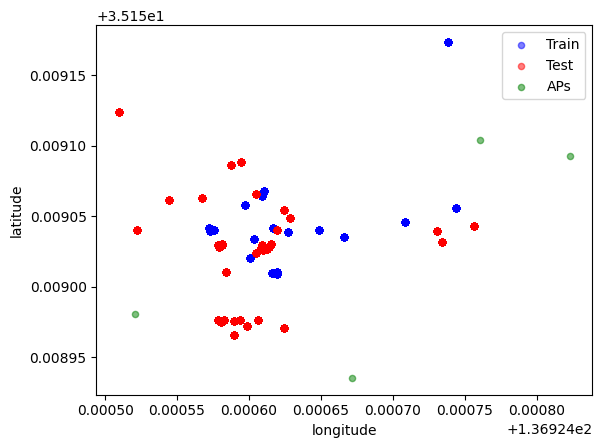

In [177]:
dot_size = 20
plt.scatter(x=train.Longitude, y=train.Latitude, c='blue', label='Train', alpha=0.5, s=dot_size)
plt.scatter(x=test.Longitude, y=test.Latitude, c='red', label='Test', alpha=0.5, s=dot_size)
plt.scatter(x=ap.ap_longitude, y=ap.ap_latitude, c='green', label='APs', alpha=0.5, s=dot_size)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend()
plt.show()

# Preprocessing and EDA

In [178]:
train['split'] = 'train'
test['split'] = 'test'

df = pd.concat([train, test]).reset_index(drop=True)
df.columns = df.columns.str.lower()

df = df.merge(ap, on='ssid', how='left')
df = df[['unixtime', 'ssid', 'frequency', 'channel', 'rssi', 'ap_latitude', 'ap_longitude', 'distance_to_ap1',
       'distance_to_ap2', 'distance_to_ap3', 'distance_to_ap4', 'latitude', 'longitude','receiver_height', 'split']]

df = df.reset_index()
df.head()

,index,unixtime,ssid,frequency,channel,rssi,ap_latitude,ap_longitude,distance_to_ap1,distance_to_ap2,distance_to_ap3,distance_to_ap4,latitude,longitude,receiver_height,split
0,0,1.695981e+09,1,2412,20,-66,35.159104,136.924761,0.0,25.822916,20.525037,5.823021,35.15901,136.924584,1.9,train
1,1,1.695981e+09,1,2412,20,-66,35.159104,136.924761,0.0,25.822916,20.525037,5.823021,35.15901,136.924584,1.9,train
2,2,1.695981e+09,1,2412,20,-66,35.159104,136.924761,0.0,25.822916,20.525037,5.823021,35.15901,136.924584,1.9,train
3,3,1.695981e+09,1,2412,20,-66,35.159104,136.924761,0.0,25.822916,20.525037,5.823021,35.15901,136.924584,1.9,train
4,4,1.695981e+09,1,2412,20,-66,35.159104,136.924761,0.0,25.822916,20.525037,5.823021,35.15901,136.924584,1.9,train


In [179]:
def preprocess(df):
  # add new features
  df['time'] = pd.to_datetime(df['unixtime'], unit='s')
  df = df.sort_values(by='time', ascending=True)
  df['utime1'] = df['unixtime'].diff()

  # get better representation of RSSI (allowing models to grasp the trend)
  df['power_rssi'] = df.apply(lambda x: power_rssi(x['rssi'], df['rssi'].min()), axis=1)
  df['zton_rssi'] = df.apply(lambda x: zton_rssi(x['rssi'], df['rssi'].min()), axis=1)

  # switch columns to give show the derived RSSI values per channel
  rdf = df.pivot(
                  index=['index'],
                  columns=['channel'],
                  values=['power_rssi', 'zton_rssi']
                ).reset_index()

  rdf.columns = ['_'.join([str(i) for i in x]) for x in rdf.columns]
  rdf.columns = rdf.columns.str.strip('_')
  df = df.merge(rdf, on='index', how='left')

  # switch columns to give show the derived RSSI values per AP
  pdf = df.pivot(
                  index=['index'],
                  columns=['ssid'],
                  values=['power_rssi', 'zton_rssi',]
                ).reset_index()

  pdf.columns = ['_'.join([str(i) for i in x]) for x in pdf.columns]
  pdf.columns = pdf.columns.str.strip('_')
  df = df.merge(pdf, on='index', how='left')

  # specify columns to drop
  rem_cols = ['index', 'time','ssid']
  df.drop(rem_cols, axis=1, inplace=True)

  for column in df.columns.difference(['latitude', 'longitude','receiver_height', 'split']):
    df[column] = replace_outliers(df[column])

  # split data into train and test as Originally intended
  train = df[df.split=='train'].drop(['split'], axis=1)
  test = df[df.split=='test'].drop(['split'], axis=1)

  # finally drop the split clumns
  df.drop(['split'], axis=1, inplace=True)

  return train, test, df

In [180]:
train_df, test_df, data = preprocess(df)
train_df.shape, test_df.shape, data.shape

((7100, 28), (7200, 28), (14300, 28))

## Vizualizations

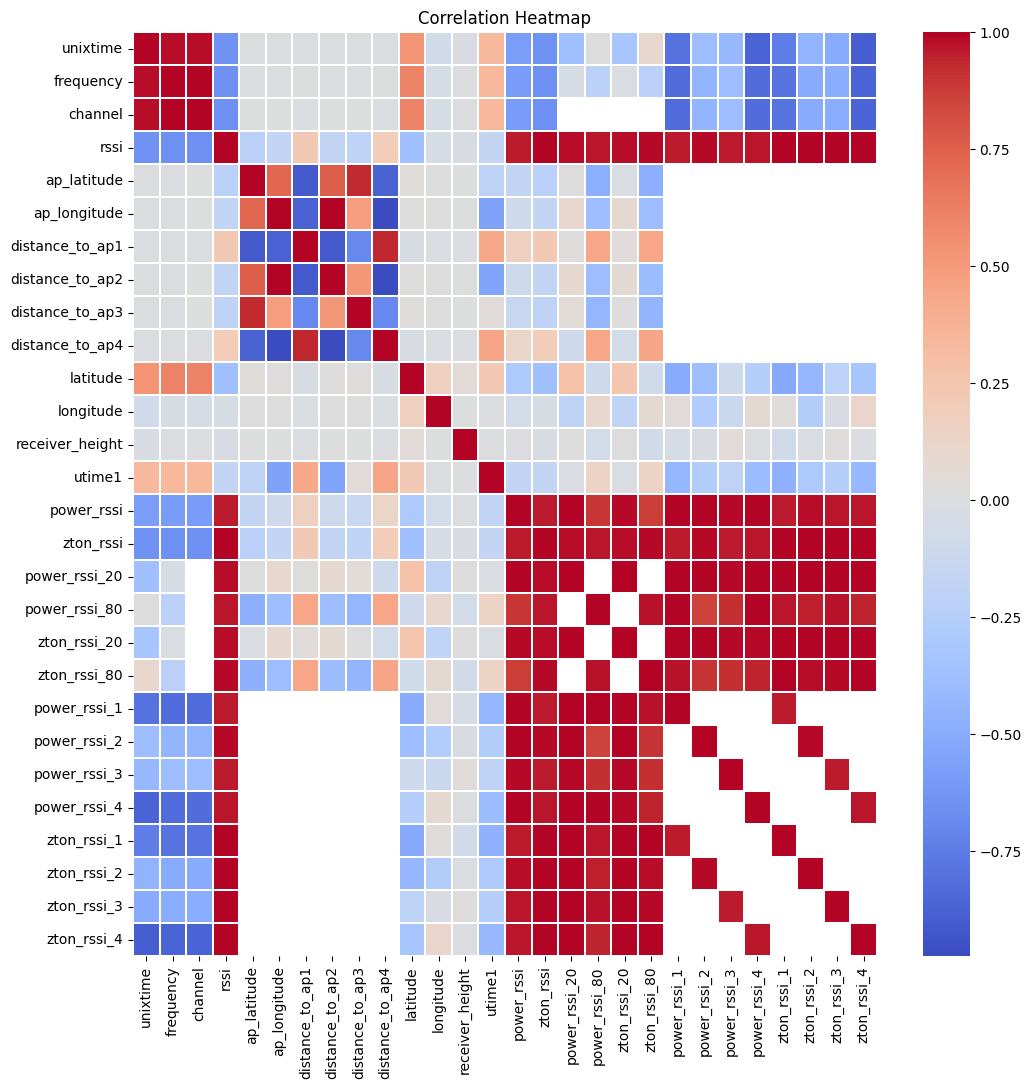

In [181]:
correlation_matrix = data.corr()

# Create a correlation heatmap using seaborn
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=False,  cmap='coolwarm', linewidths=0.1)
plt.title('Correlation Heatmap')
plt.show()

<Axes: xlabel='rssi', ylabel='Count'>

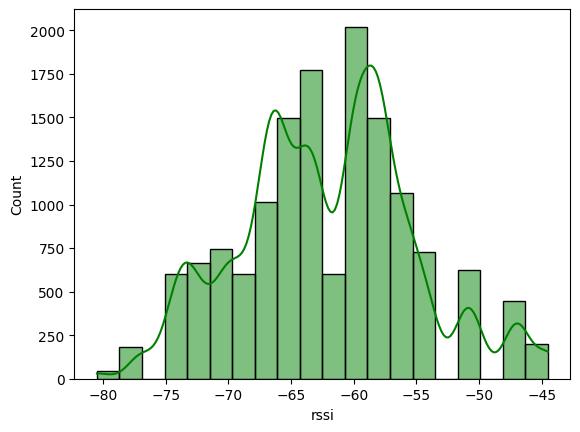

In [182]:
sns.histplot(data.rssi, kde=True, bins=20, color="green")

<Axes: xlabel='zton_rssi', ylabel='Count'>

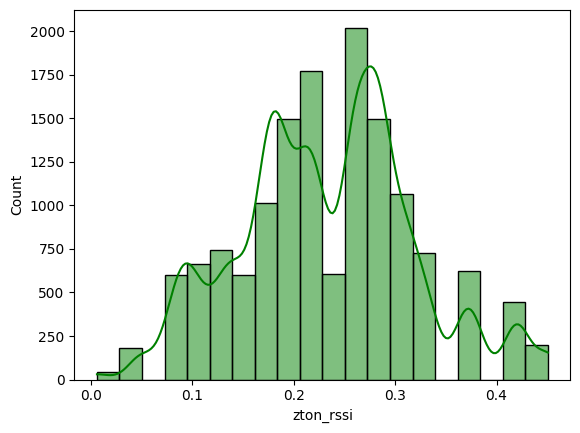

In [183]:
sns.histplot(data.zton_rssi, kde=True, bins=20, color="green")

<Axes: xlabel='power_rssi', ylabel='Count'>

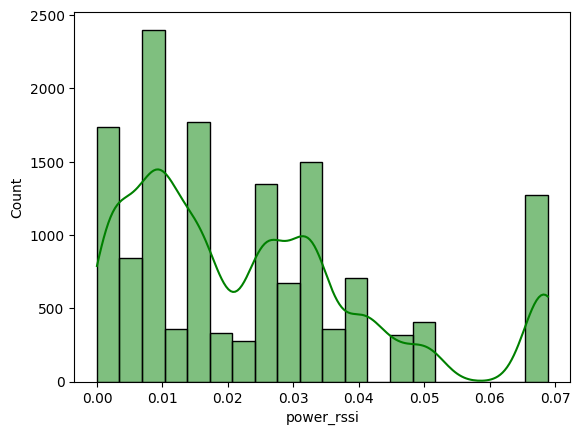

In [184]:
sns.histplot(data.power_rssi, kde=True, bins=20, color="green")

# Modelling

## Features

In [185]:
y_cols = ['latitude', 'longitude','receiver_height']
x_cols = train_df.columns.difference(y_cols)

X = train_df[x_cols]
y = train_df[y_cols]
X.shape, y.shape

((7100, 25), (7100, 3))

## Required (Using The Designated Test set for Evaluation)
**Training Set:** 7100 Samples  
**Evaluation Set:** 7200 Samples  
The provided Training Set was slightly smaller than the Evaluation set.

In [186]:
cats = ['channel']
base1 = HIST(
              loss='absolute_error',
              learning_rate=0.2,
              max_iter=1000,
              categorical_features=cats,
              min_samples_leaf=12,
              max_depth=12,
              l2_regularization = 0.7,
              random_state=0
            )

model1 = MO(base1)

model1.fit(X, y)

MultiOutputRegressor(estimator=HistGradientBoostingRegressor(categorical_features=['channel'],
                                                             l2_regularization=0.7,
                                                             learning_rate=0.2,
                                                             loss='absolute_error',
                                                             max_depth=12,
                                                             max_iter=1000,
                                                             min_samples_leaf=12,
                                                             random_state=0))

In [187]:
X_test = test_df[x_cols]
y_true = test_df[y_cols]

model1_preds = model1.predict(X_test)

ss = match_precision(model1_preds)

# Evaluate the model
evaluate(y_true, model1_preds)
av, ma, m1_errors = loc_eval(y_true, ss)
# Average Error (m): 2.7240647037291645
# Maximum Error (m): 16.308616873853733

MSE:  0.12523710866476814
RMSE: 0.20433900182953657
MAE:  0.11595069506497328
R2:   0.14526802882902612
Average Error (m): 2.7244332503304407
Maximum Error (m): 16.308616869896873


<Axes: title={'center': 'Distribution of Localization Errors in 3D Space (metres) - Single Batch Training'}, ylabel='Count'>

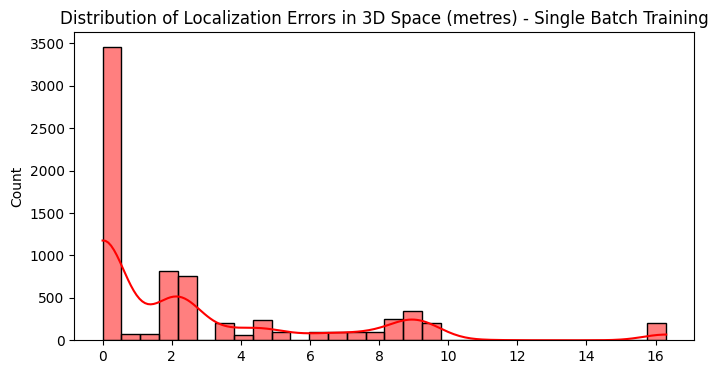

In [188]:
plt.figure(figsize=(8,4))
plt.title("Distribution of Localization Errors in 3D Space (metres) - Single Batch Training")
sns.histplot(m1_errors, kde=True, bins=30, color="red")

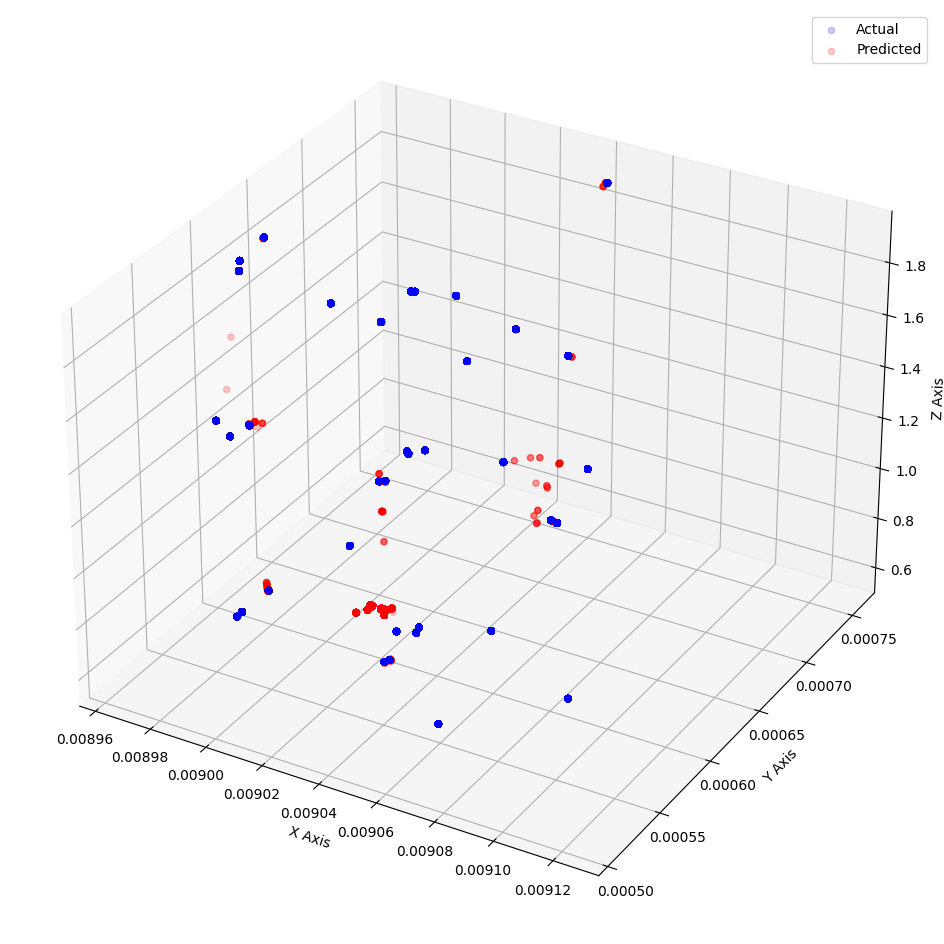

In [189]:
plot_3d(y_true, model1_preds)

In [192]:
# Training with Stratified KFold
# define categorical columns
cats = ['channel']

# train model
skf_model1 = train_skf(X, y, cats)

Average Error (m): 0.22577904727636924
Maximum Error (m): 12.027276278666694
Average Error (m): 0.3079341826589604
Maximum Error (m): 16.056757044858433
Average Error (m): 0.3715551206078344
Maximum Error (m): 16.40310585647239
Average Error (m): 0.4176103018627532
Maximum Error (m): 16.067863301104076
Average Error (m): 0.3840439156967417
Maximum Error (m): 16.056802248253053
Average Error (m): 0.35261508007542625
Maximum Error (m): 7.779754969497503
Mean Average Error: 0.3432562746963475
Mean Maximum Error: 14.065259949808691


In [193]:
# evaluate on the Unseen Test Data
X_test = test_df[x_cols]
y_true = test_df[y_cols]

skf_model1_preds = skf_model1.predict(X_test)

# Evaluate the model
evaluate(y_true, skf_model1_preds)
av, ma, skf1_errors = loc_eval(y_true, skf_model1_preds)

MSE:  0.13848545105870066
RMSE: 0.21487440575560965
MAE:  0.13934232011927097
R2:   0.09656653454331383
Average Error (m): 2.828504539679283
Maximum Error (m): 16.308664303967358


<Axes: title={'center': 'Distribution of Localization Errors in 3D Space (metres) - SKFold Train'}, ylabel='Count'>

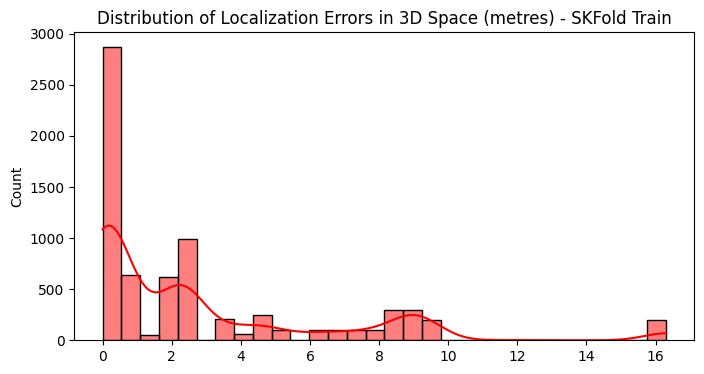

In [194]:
plt.figure(figsize=(8,4))
plt.title("Distribution of Localization Errors in 3D Space (metres) - SKFold Train")
sns.histplot(skf1_errors, kde=True, bins=30, color="red")

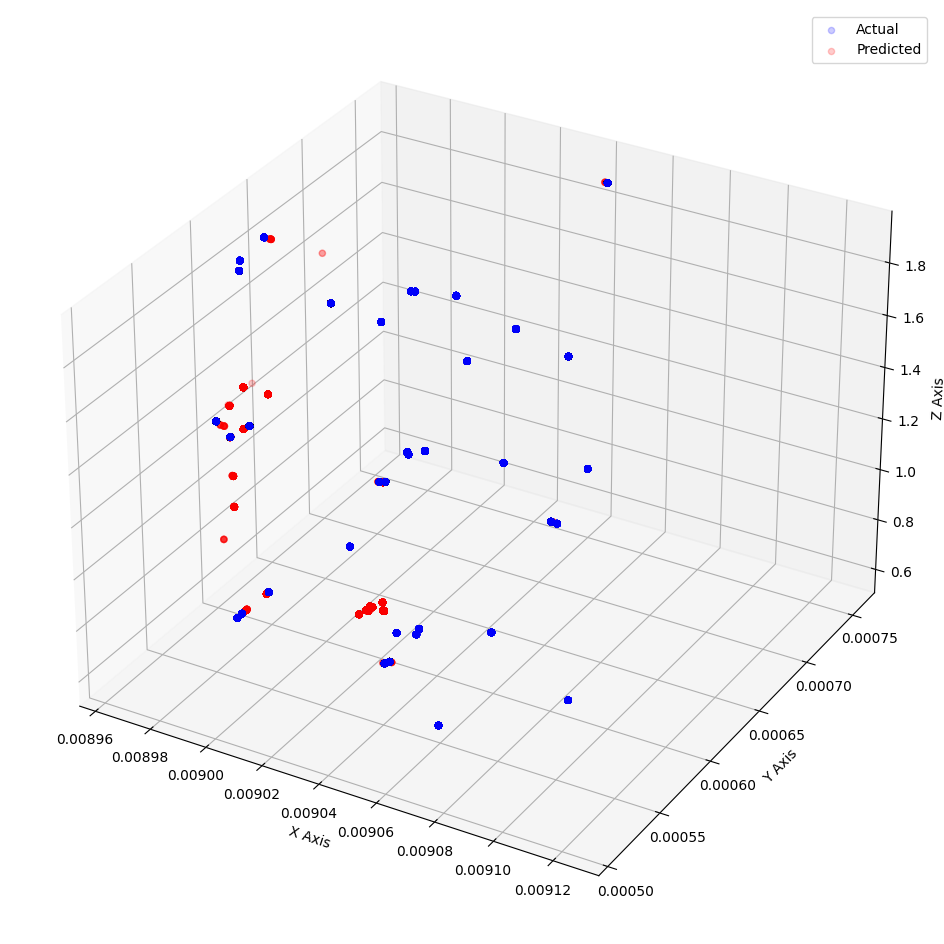

In [195]:
plot_3d(y_true, skf_model1_preds)

## Combining Designated Train and Test, and use 25% as evaluation set
**Training Set:** 10,725 Samples  
**Evaluation Set:** 3,575 Samples  

In [196]:
from sklearn.multioutput import MultiOutputRegressor as MO
from sklearn.model_selection import train_test_split as tts

y_cols = ['latitude', 'longitude','receiver_height']
x_cols = data.columns.difference(y_cols)

base2 = HIST(
            loss='absolute_error',
            learning_rate=0.2,
            max_iter=1000,
            categorical_features=cats,
            min_samples_leaf=12,
            max_depth=12,
            l2_regularization = 0.7,
            random_state=0
            )

model2 = MO(base2)

X = data[x_cols]
y = data[y_cols]

x_train, x_test, y_train, y_test = tts(X, y, test_size=0.25, random_state=0)

x_train.shape, x_test.shape

((10725, 25), (3575, 25))

In [197]:
model2.fit(x_train, y_train)

MultiOutputRegressor(estimator=HistGradientBoostingRegressor(categorical_features=['channel'],
                                                             l2_regularization=0.7,
                                                             learning_rate=0.2,
                                                             loss='absolute_error',
                                                             max_depth=12,
                                                             max_iter=1000,
                                                             min_samples_leaf=12,
                                                             random_state=0))

In [198]:
preds2 = model2.predict(x_test)

evaluate(y_test, preds2)
a, m, m2_errors = loc_eval(y_test, preds2)

MSE:  0.04114309094585733
RMSE: 0.11711542377373275
MAE:  0.06903462736688874
R2:   0.8098649072360854
Average Error (m): 0.5364307328097532
Maximum Error (m): 16.060508957265153


<Axes: title={'center': 'Distribution of Localization Errors in 3D Space (metres) - Single Batch Train (B)'}, ylabel='Count'>

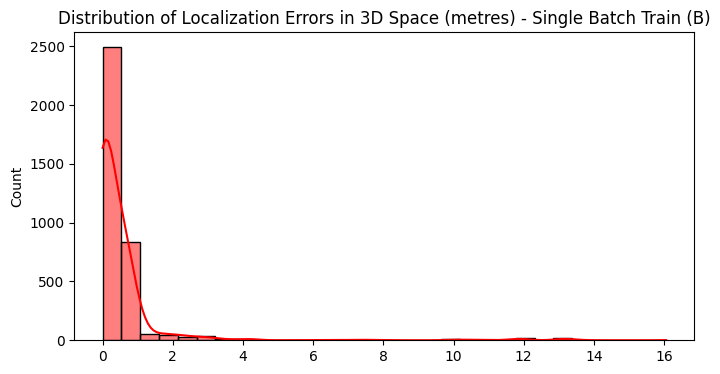

In [199]:
plt.figure(figsize=(8,4))
plt.title("Distribution of Localization Errors in 3D Space (metres) - Single Batch Train (B)")
sns.histplot(m2_errors, kde=True, bins=30, color="red")

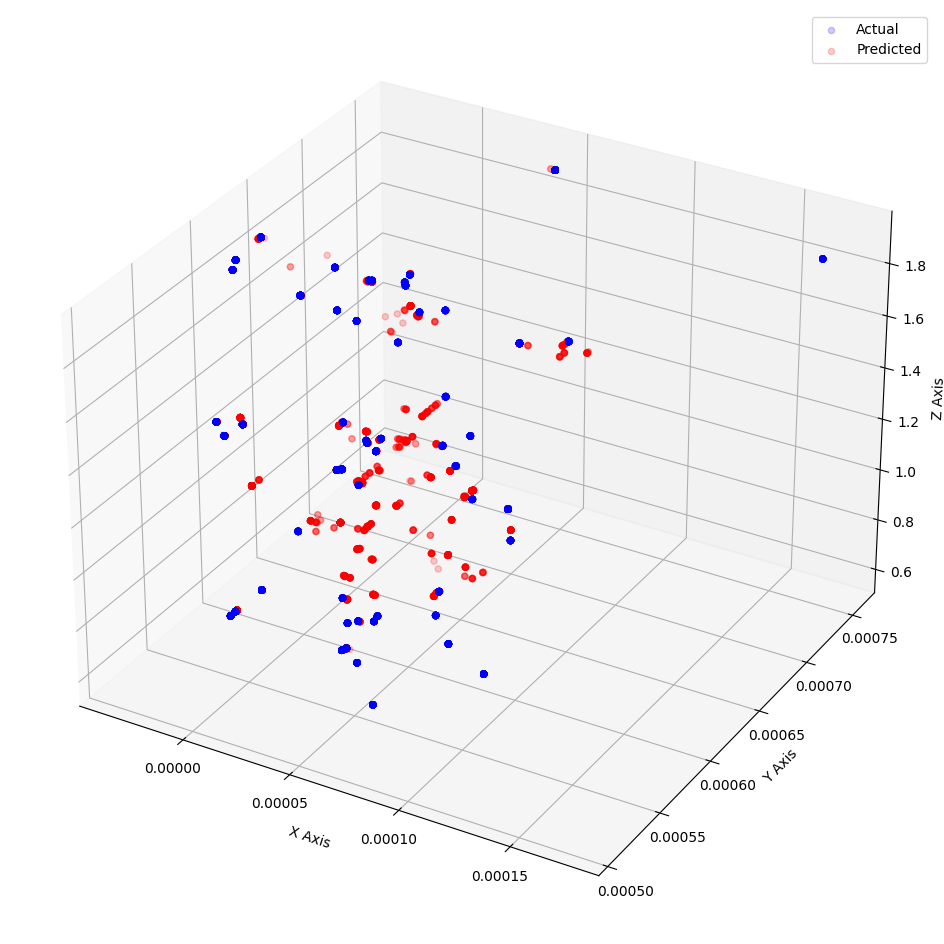

In [200]:
plot_3d(y_test, preds2)

In [201]:
# Training with Stratified KFold
# define categorical columns
cats = ['channel']

# train model
skf_model2 = train_skf(x_train, y_train, cats)

Average Error (m): 0.5027211872569202
Maximum Error (m): 13.327242268146213
Average Error (m): 0.4354710518283999
Maximum Error (m): 12.185988255727267
Average Error (m): 0.5149316853951568
Maximum Error (m): 16.056757044858433
Average Error (m): 0.6261705520577456
Maximum Error (m): 13.168478071860253
Average Error (m): 0.39310166934282387
Maximum Error (m): 16.056827683175772
Average Error (m): 0.5148789824973785
Maximum Error (m): 16.056765160007945
Mean Average Error: 0.4978791880630708
Mean Maximum Error: 14.475343080629314


In [202]:
# evaluate on the Unseen Test Data
skf_model2_preds = skf_model2.predict(x_test)

# Evaluate the model
evaluate(y_test, skf_model2_preds)
av, ma, skf2_errors = loc_eval(y_test, skf_model2_preds)

MSE:  0.011706947701315135
RMSE: 0.06247586112999553
MAE:  0.01620169395255502
R2:   0.9105838003434688
Average Error (m): 0.4733212159947001
Maximum Error (m): 16.0567625331605


<Axes: title={'center': 'Distribution of Localization Errors in 3D Space (metres) - SKFold Train (B)'}, ylabel='Count'>

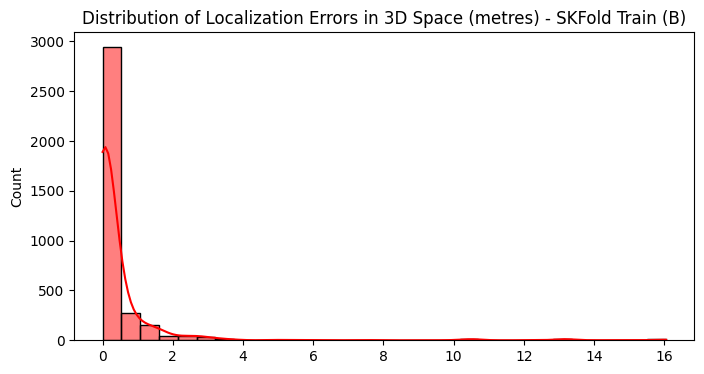

In [203]:
plt.figure(figsize=(8,4))
plt.title("Distribution of Localization Errors in 3D Space (metres) - SKFold Train (B)")
sns.histplot(skf2_errors, kde=True, bins=30, color="red")

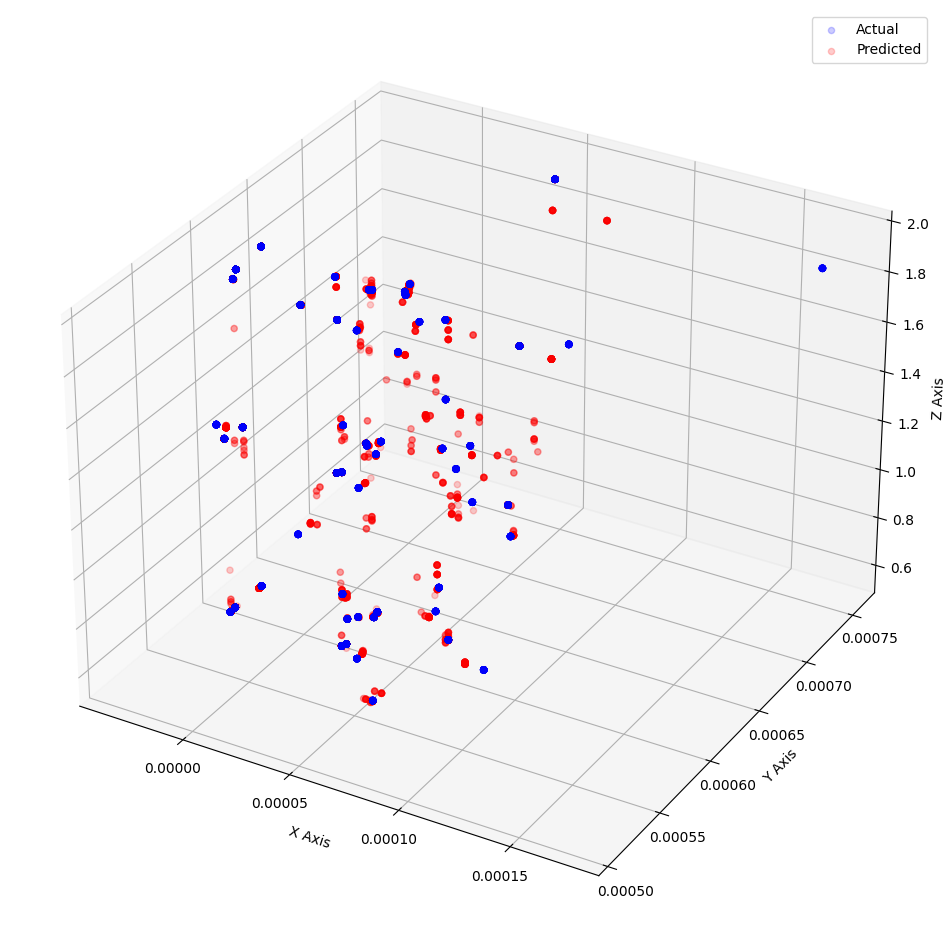

In [204]:
plot_3d(y_test, skf_model2_preds)